<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dynamical-System" data-toc-modified-id="Dynamical-System-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dynamical System</a></span></li><li><span><a href="#Fundamentals-of-a-dynamical-system" data-toc-modified-id="Fundamentals-of-a-dynamical-system-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fundamentals of a dynamical system</a></span><ul class="toc-item"><li><span><a href="#Interpolation" data-toc-modified-id="Interpolation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Interpolation</a></span></li><li><span><a href="#Differential-equation" data-toc-modified-id="Differential-equation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Differential equation</a></span><ul class="toc-item"><li><span><a href="#Velocity" data-toc-modified-id="Velocity-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Velocity</a></span></li></ul></li><li><span><a href="#Lagrangian-particle-trajectories" data-toc-modified-id="Lagrangian-particle-trajectories-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Lagrangian particle trajectories</a></span></li><li><span><a href="#Flow-map" data-toc-modified-id="Flow-map-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Flow map</a></span></li></ul></li><li><span><a href="#Tensors-and-gradients" data-toc-modified-id="Tensors-and-gradients-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tensors and gradients</a></span><ul class="toc-item"><li><span><a href="#Gradient-of-the-flow-map" data-toc-modified-id="Gradient-of-the-flow-map-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Gradient of the flow map</a></span></li><li><span><a href="#Gradient-of-velocity" data-toc-modified-id="Gradient-of-velocity-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Gradient of velocity</a></span></li><li><span><a href="#Vorticity-tensor" data-toc-modified-id="Vorticity-tensor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Vorticity tensor</a></span></li><li><span><a href="#Spin-tensor" data-toc-modified-id="Spin-tensor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Spin tensor</a></span></li></ul></li></ul></div>

In [1]:
# Import standard python libraries
import numpy as np
from math import sqrt
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed

from ipynb.fs.defs.eigen import *
from ipynb.fs.defs.check_location import *

# Dynamical System

The class *Dynamical\_System* stores all the properties of a dynamical system. The methods and variables defined within *Dynamical\_System* apply to general two dimensional dynamical systems.

It is assumed that the velocity data is given over a gridded domain. The spacing of the meshgrid in the x-direction need not be equal the spacing of the meshgrid in the y-direction and it can deal with both steady and unsteady velocity fields.

Lagrangian particle trajectories are time-parametrized curves $ \mathbf{x}(t; t_0, \mathbf{x}_0) $ starting at $ \mathbf{x}_0 $ at time $ t_0 $ which are governed by the differential equation

\begin{equation} \mathbf{\dot{x}}(t)= \mathbf{v}(\mathbf{x}, t) = \begin{pmatrix} u(x, y, t) \\ v(x, y, t) \end{pmatrix} \label{eq: dxdt}, \end{equation}
where $ \mathbf{x}=\begin{pmatrix} x \\ y \end{pmatrix} \in U $ and times $ t \in [t_0, t_N] $.

As suggested by [fig 1](#fig1), the particle trajectories generated by the velocity-field $ \mathbf{v}(\mathbf{x}, t) $ are defined over a domain $ U $ with boundary $ \partial U $ over the finite time interval $ t \in [t_0, t_N] $.

<a id='fig1'></a>

| 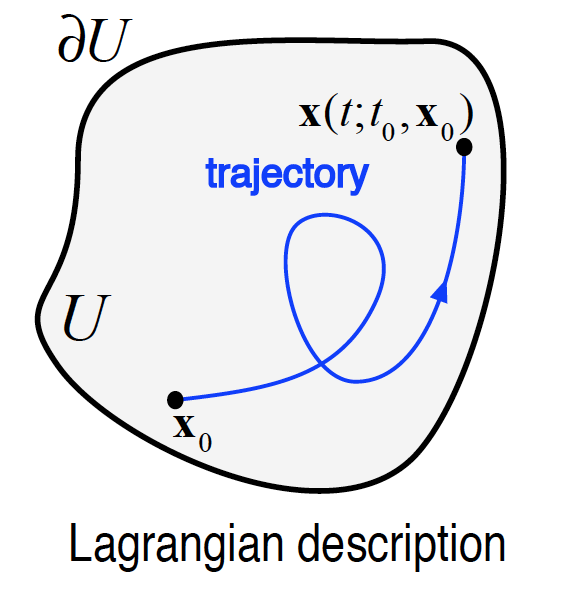 |
|:--:| 
| *fig 1* Lagrangian Particle Trajectories |

In [2]:
class Dynamical_System():
    
    def __init__(self, params_data, params_DS):
        
        # Meshgrid
        self.X, self.Y, self.Z = params_data["X"], params_data["Y"], params_data["Z"]
        
        self.Xmin = np.min(self.X)
        self.Xmax = np.max(self.X)
        self.Ymin = np.min(self.Y)
        self.Ymax = np.max(self.Y)
        self.Zmin = np.min(self.Z)
        self.Zmax = np.max(self.Z)
        
        # Time
        self.Time = params_data["Time"].reshape(1, -1)
        
        # Velocity field
        self.U = params_data["U"]
        self.V = params_data["V"]
        self.W = params_data["W"]
        
        # Specify steady/unsteady flow field. {True, False}
        self.boolean_unsteady = bool(int(self.U.ndim - self.X.ndim))
        
        # Define domain and time resolution
        if self.boolean_unsteady:
        
            self.defined_domain = np.isfinite(np.sum(self.U, axis = -1)).astype(int)
                      
            self.dt_data = self.Time[0, 1]-self.Time[0, 0]
        
        else:
            
            self.defined_domain = np.isfinite(self.U).astype(int)
            
            self.dt_data = 0
        
        # Global (gridded) interpolants cannot deal with nan-values 
        # --> set nan values to zero.
        self.U[np.isnan(self.U)] = 0
        self.V[np.isnan(self.V)] = 0
        self.W[np.isnan(self.W)] = 0
        
        self.dx_data = self.X[0, 1, 0]-self.X[0, 0, 0]
        self.dy_data = self.Y[1, 0, 0]-self.Y[0, 0, 0]
        self.dz_data = self.Z[0, 0, 1]-self.Z[0, 0, 0]
        
        self.original_grid_spacing = [self.dx_data, self.dy_data, self.dz_data]
        
        # Number of cores to be used for parallel computing whenever possible.
        self.Ncores = params_data["Ncores"]
        
        # Phase space dimension
        self.dim = self.X.ndim
        
        # Specify whether the flow has periodic boundary conditions.
        self.periodic = params_data["Periodic"]
        
        # time interval [t0, tN]
        self.time = params_DS["time"]
        
        # Initial time
        self.t0 = self.time[0]

        # Final time
        self.tN = self.time[-1]
        
        # Discrete length of time array
        self.lenT = len(self.time)
        
        if len(self.time)>1:
            
            # time step-size
            self.dt = self.time[1]-self.time[0]
        
        else:
            
            self.dt = 0
        
        # x, y/long, lat coordinates
        self.X_domain = params_DS["X_domain"]
        self.Y_domain = params_DS["Y_domain"]
        self.Z_domain = params_DS["Z_domain"]
        
        # define grid spacing
        self.dx = self.X_domain[0, 1, 0]-self.X_domain[0, 0, 0]
        self.dy = self.Y_domain[1, 0, 0]-self.Y_domain[0, 0, 0]
        self.dz = self.Z_domain[0, 0, 1]-self.Z_domain[0, 0, 0]
        
        # Boundaries
        self.xmin = self.X_domain[0, 0, 0]
        self.xmax = self.X_domain[0, -1, 0]
        self.ymin = self.Y_domain[0, 0, 0]
        self.ymax = self.Y_domain[-1, 0, 0]
        self.zmin = self.Z_domain[0, 0, 0]
        self.zmax = self.Z_domain[0, 0, -1]
    
        self.len_X = self.X_domain.shape[1]
        self.len_Y = self.Y_domain.shape[0]
        self.len_Z = self.Z_domain.shape[2]

# Fundamentals of a dynamical system

In the following section we introduce the computational aspects involved when computing lagrangian particle trajectories from discrete velocity data.

<a id='INTERPOLATION'></a>
## Interpolation

As we are dealing with a discrete representation of the velocity-field $ \mathbf{v}(\mathbf{x}, t) $ defined on a domain $ \mathbf{x} \in U $ over the time interval $ [t_0, t_N] $, we seek to generally evaluate the velocity of the particle at arbitrary locations $ \mathbf{x}=\begin{pmatrix} x \\ y \end{pmatrix} \in U $ at times $ t \in [t_0, t_N] $.

The interpolant can deal with both steady and unsteady 2D velocity fields. For steady velocity fields we avoid interpolating with respect to time. For unsteady velocity fields the interpolation with respect to time is linear by default, whereas the interpolation with respect to space can be chosen to be either "linear" or "cubic". The default value for spatial interpolation is "cubic".

In [3]:
    def _Interpolation_velocity(self):
        
        # import RegularGridInterpolator from scipy
        from scipy.interpolate import RegularGridInterpolator
        
        # if velocity field is unsteady, then spatial interpolation
        # is computed at each time step.
        
        if self.boolean_unsteady:
            
            # define u, v interpolants
            self.Interpolant_u = []
            self.Interpolant_v = []
            self.Interpolant_w = []
                    
            for j in range(self.U.shape[3]):
                
                self.Interpolant_u.append(RegularGridInterpolator((self.Y[:,0,0], self.X[0,:,0], self.Z[0,0,:]), self.U[:,:,:,j]))
                self.Interpolant_v.append(RegularGridInterpolator((self.Y[:,0,0], self.X[0,:,0], self.Z[0,0,:]), self.V[:,:,:,j]))
                self.Interpolant_w.append(RegularGridInterpolator((self.Y[:,0,0], self.X[0,:,0], self.Z[0,0,:]), self.W[:,:,:,j]))               
        
        # if velocity field is steady, then spatial interpolation
        # is computed only once.
        
        else:
            
            self.Interpolant_u = RegularGridInterpolator((self.Y[:,0,0], self.X[0,:,0], self.Z[0,0,:]), self.U)
            self.Interpolant_v = RegularGridInterpolator((self.Y[:,0,0], self.X[0,:,0], self.Z[0,0,:]), self.V)
            self.Interpolant_w = RegularGridInterpolator((self.Y[:,0,0], self.X[0,:,0], self.Z[0,0,:]), self.W)

<a id='Differential_equation'></a>
## Differential equation
**\_dxdt** calculates the velocity of the lagrangian particle at (*x*,*t*).

In [4]:
    def _dxdt(self, t, x):
        
        if self.periodic[0]:
            if x[0] < self.xmin:
                x[0] = self.xmax+x[0]-self.xmin
            elif x[0] > self.xmax:
                x[0] = self.xmin+x[0]-self.xmax
                
        if self.periodic[1]:
            if x[1] < self.ymin:
                x[1] = self.ymax+x[1]-self.ymin
            elif x[1] > self.ymax:
                x[1] = self.ymin+x[1]-self.ymax
    
        if self.periodic[2]:
            if x[2] < self.zmin:
                x[2] = self.zmax+x[2]-self.zmin
            elif x[2] > self.zmax:
                x[2] = self.zmin+x[2]-self.zmax

        # If particle inside defined domain
        # then velocity at (x, t)
        # can be evaluated using the interpolant

        return self._velocity(t, x)

<a id='Velocity_in_defined_domain'></a>
### Velocity

**\_velocity** computes the velocity of a particle.

In [12]:
    def _velocity(self, t, x):
        
        # Unsteady case
        if self.boolean_unsteady:
            
            k = int(t/self.dt_data)
            
            # evaluate velocity field at time t
            ui = self.Interpolant_u[k](x[1], x[0], x[2])[0][0]
            uf = self.Interpolant_u[k+1](x[1], x[0], x[2])[0][0]
            u = ((k+1)*self.dt_data-t)/self.dt_data*ui + (t-k*self.dt_data)/self.dt_data*uf

            vi = self.Interpolant_v[k](x[1], x[0], x[2])[0][0]
            vf = self.Interpolant_v[k+1](x[1], x[0], x[2])[0][0]
            v = ((k+1)*self.dt_data-t)/self.dt_data*vi + (t-k*self.dt_data)/self.dt_data*vf
            
            wi = self.Interpolant_w[k](x[1], x[0], x[2])[0][0]
            wf = self.Interpolant_w[k+1](x[1], x[0], x[2])[0][0]
            w = ((k+1)*self.dt_data-t)/self.dt_data*wi + (t-k*self.dt_data)/self.dt_data*wf
        
        # Steady case        
        elif self.boolean_unsteady == False:
            
            u = self.Interpolant_u([x[1], x[0], x[2]])[0]
            v = self.Interpolant_v([x[1], x[0], x[2]])[0]
            w = self.Interpolant_w([x[1], x[0], x[2]])[0]
        
        vel = [np.around(u, 10), np.around(v, 10), np.around(w, 10)]
        
        return vel

<a id='Lagrangian_particle_trajectories'></a>
## Lagrangian particle trajectories

**_trajectory** numerically computes the trajectory of the particle over the time-interval specified by the array **time** starting at the position **x** subject to the non-autonomous differential equation \ref{eq: dxdt}. If the particle enters a region where the velocity field is not defined, then the trajectory is regarded as "nan" and the integration stops.

In [6]:
    def _trajectory(self, time, x):    
        
        # time-interval [t0,tN] over which to integrate
        t = [time[0], time[-1]]
        
        # time-array at which trajectory must be evaluated
        t_eval = time.copy()
        
        # Step-size
        dt = time[1]-time[0]
                    
        sol = solve_ivp(self._dxdt, t, x, 'RK45', t_eval, rtol=1e-6, atol=1e-6, first_step = dt)
            
        # Initialize velocity array
        velocity = np.zeros((self.dim, len(time)))
            
        for i in range(sol.y.shape[1]-1):
                
            velocity[0, :] = (sol.y[0,i+1]-sol.y[0,i])/dt
            velocity[1, :] = (sol.y[1,i+1]-sol.y[1,i])/dt
            velocity[2, :] = (sol.y[2,i+1]-sol.y[2,i])/dt
        
        trajectory = sol.y.copy()
        
        for i in range(sol.y.shape[1]):
    
            if self.periodic[0]:
                if sol.y[0,i] < self.xmin:
                    trajectory[0, i] = sol.y[0,i]+self.xmax-self.xmin
                elif sol.y[0,i] > self.xmax:
                    trajectory[0, i] = sol.y[0,i]+self.xmin-self.xmax
           
            if self.periodic[1]:
                if sol.y[1,i] < self.ymin:
                    trajectory[1, i] = sol.y[1,i]+self.ymax-self.ymin
                elif sol.y[1,i] > self.ymax:
                    trajectory[1, i] = sol.y[1,i]+self.ymin-self.ymax

            if self.periodic[2]:
                if sol.y[2,i] < self.zmin:
                    trajectory[2, i] = sol.y[2,i]+self.zmax-self.zmin
                elif sol.y[2,i] > self.zmax:
                    trajectory[2, i] = sol.y[2,i]+self.zmin-self.zmax
            
        return trajectory, velocity

## Flow map

The flow map $ F_{t_0}^t: \mathbf{x} \rightarrow \mathbf{x}(t) $ maps initial positions $ \mathbf{x}_0 $ forward to $ \mathbf{x}(t) $.

In [7]:
    def _Fmap(self, x, time):
            
        F_t0_t = self._trajectory(x, time)[0][:, -1]
            
        return F_t0_t

# Tensors and gradients

<a id='Gradient_of_the_flow_map'></a>
## Gradient of the flow map

In [8]:
    def _grad_Fmap(self, time, x, grid_spacing):
    
        # Initialized gradient of flow map
        grad_Fmap = np.zeros((self.dim, self.dim))
        
        xL = x-np.array([1, 0, 0])*grid_spacing*self.dx
        xLend = self._trajectory(xL, time)[0][:, -1]
        
        xR = x+np.array([1, 0, 0])*grid_spacing*self.dx
        xRend = self._trajectory(xR, time)[0][:, -1]
        
        xD = x-np.array([0, 1, 0])*grid_spacing*self.dy
        xDend = self._trajectory(xD, time)[0][:, -1]
        
        xU = x+np.array([0, 1, 0])*grid_spacing*self.dy
        xUend = self._trajectory(xU, time)[0][:, -1]
        
        xF = x-np.array([0, 0, 1])*grid_spacing*self.dz
        xFend = self._trajectory(xF, time)[0][:, -1]
        
        xB = x+np.array([0, 0, 1])*grid_spacing*self.dz
        xBend = self._trajectory(xB, time)[0][:, -1]
        
        grad_Fmap[0, 0] = (xRend[0]-xLend[0])/(2*grid_spacing*self.dx)
        grad_Fmap[1, 0] = (xRend[1]-xLend[1])/(2*grid_spacing*self.dx)
        grad_Fmap[2, 0] = (xRend[2]-xLend[2])/(2*grid_spacing*self.dx)
        
        grad_Fmap[0, 1] = (xUend[0]-xDend[0])/(2*grid_spacing*self.dy)
        grad_Fmap[1, 1] = (xUend[1]-xDend[1])/(2*grid_spacing*self.dy)
        grad_Fmap[2, 1] = (xUend[2]-xDend[2])/(2*grid_spacing*self.dy)
        
        grad_Fmap[0, 1] = (xBend[0]-xFend[0])/(2*grid_spacing*self.dz)
        grad_Fmap[1, 1] = (xBend[1]-xFend[1])/(2*grid_spacing*self.dz)
        grad_Fmap[2, 2] = (xBend[2]-xFend[2])/(2*grid_spacing*self.dz)
        
        return grad_Fmap

## Gradient of velocity

In [9]:
    def _grad_vel(self, t, x, grid_spacing):
        
        grad_vel = np.zeros((self.dim, self.dim))
    
        xL = x-np.array([1, 0, 0])*grid_spacing*self.dx
        vLend = self._dxdt(t, xL)
        
        xR = x+np.array([1, 0, 0])*grid_spacing*self.dx
        vRend = np.array(self._dxdt(t, xR))
        
        xD = x-np.array([0, 1, 0])*grid_spacing*self.dy
        vDend = self._dxdt(t, xD)
        
        xU = x+np.array([0, 1, 0])*grid_spacing*self.dy
        vUend = self._dxdt(t, xU)
        
        xF = x-np.array([0, 0, 1])*grid_spacing*self.dz
        vFend = self._dxdt(t, xF)
        
        xB = x+np.array([0, 0, 1])*grid_spacing*self.dz
        vBend = self._dxdt(t, xB)
        
        grad_vel[0, 0] = (vRend[0]-vLend[0])/(2*grid_spacing)
        grad_vel[1, 0] = (vRend[1]-vLend[1])/(2*grid_spacing)
        grad_vel[2, 0] = (vRend[2]-vLend[2])/(2*grid_spacing)
        
        grad_vel[0, 1] = (vUend[0]-vDend[0])/(2*grid_spacing)
        grad_vel[1, 1] = (vUend[1]-vDend[1])/(2*grid_spacing)
        grad_vel[2, 1] = (vUend[2]-vDend[2])/(2*grid_spacing)
        
        grad_vel[0, 1] = (vBend[0]-vFend[0])/(2*grid_spacing)
        grad_vel[1, 1] = (vBend[1]-vFend[1])/(2*grid_spacing)
        grad_vel[2, 2] = (vBend[2]-vFend[2])/(2*grid_spacing)
                
        return grad_vel

## Vorticity tensor

In [10]:
    def _vorticity_tensor(self, t, x, grid_spacing):
        
        grad_vel = self._grad_vel(t, x, grid_spacing)
    
        return .5*(grad_vel-grad_vel.T)

## Spin tensor

In [11]:
    def _spin_tensor(self, t, x, grid_spacing):
        
        grad_vel = self._grad_vel(t, x, grid_spacing)
        
        return .5*(grad_vel+grad_vel.T)